# Wavelenth calibration

This notebook assumes you've completed the Spectroscopic Trace process and have a trace handy.

In [52]:
from PIL import Image
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background')

In [53]:
hg_filename = "hg_lamp_1-sixteenth_s.bmp"
kr_filename = "kr_lamp_p6.bmp"
ne_filename = "ne_lamp_1s.bmp"

In [54]:
hg_image = np.array(Image.open(hg_filename))
kr_image = np.array(Image.open(kr_filename))
ne_image = np.array(Image.open(ne_filename))

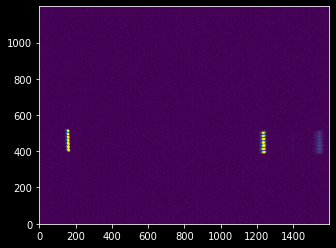

In [55]:
pl.imshow(hg_image)

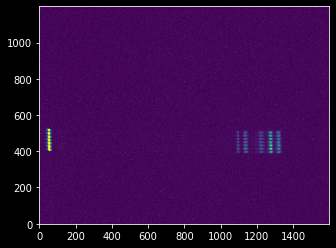

In [56]:
pl.imshow(kr_image)

Re-create our trace model

In [57]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D
trace_model = Polynomial1D(degree=3, c0=453.31622273, c1=-0.01256666, c2=-0.00000651, c3=0.00000001)
trace_profile_model = Gaussian1D(amplitude=123.66048266, mean=0.17770841, stddev=5.11726616)
xaxis = np.arange(hg_image.shape[1])
trace_center = trace_model(xaxis)
npixels_to_cut=15
yaxis = np.arange(-npixels_to_cut, npixels_to_cut)
model_trace_profile = trace_profile_model(yaxis)

In [58]:
hg_spectrum = np.array([np.average(hg_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [59]:
ne_spectrum = np.array([np.average(ne_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [60]:
kr_spectrum = np.array([np.average(kr_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

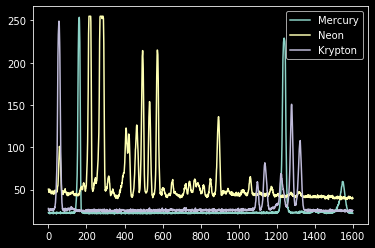

In [61]:
_=pl.plot(xaxis, hg_spectrum, label='Mercury')
_=pl.plot(xaxis, ne_spectrum, label='Neon')
_=pl.plot(xaxis, kr_spectrum, label='Krypton')
_=pl.legend(loc='best')

We now have spectra of a mercury lamp, a neon lamp, and a krypton lamp.

If we have no prior knowledge, we have to do some guess-and-check, but wikipedia's a decent resource to point us at the right line lists:

 * https://en.wikipedia.org/wiki/Mercury-vapor_lamp#Emission_line_spectrum
 * https://en.wikipedia.org/wiki/Gas-discharge_lamp#Color

In [62]:
from IPython.display import Image

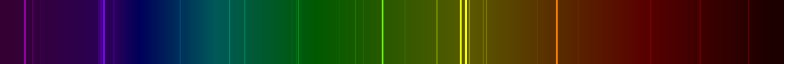

In [63]:
Image("https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg")

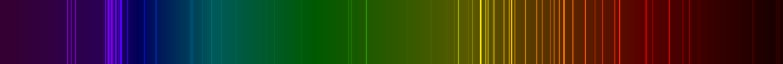

In [64]:
Image("https://upload.wikimedia.org/wikipedia/commons/9/99/Neon_spectra.jpg")

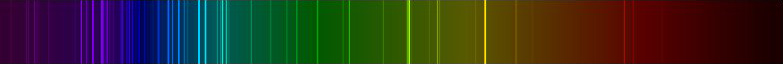

In [65]:
Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Krypton_Spectrum.jpg")

In [66]:
from astropy import units as u

Start with mercury...

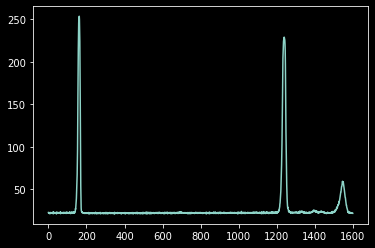

In [67]:
pl.plot(xaxis, hg_spectrum)

In [99]:
# Guessing these is hard and takes experience
# I figured this out by noting that an A-star we observed, Deneb, had an absorption line around pixel ~750
# That absorption line pretty much has to be H-alpha or H-beta
guessed_wavelengths = [546.1, 435.8, 404.7]
guessed_xvals = [165, 1230, 1550]

We can do a lot better at determining the X-values:

In [140]:
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels], weights=hg_spectrum[g-npixels:g+npixels])
                         for g in guessed_xvals]
improved_xval_guesses

[161.38867357782897, 1234.159960507142, 1548.7245458155203]

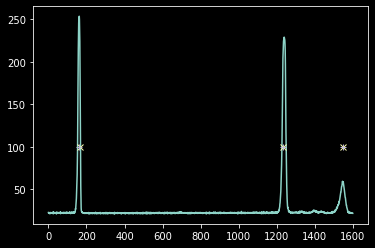

In [141]:
pl.plot(xaxis, hg_spectrum)
pl.plot(guessed_xvals, [100]*3, 'x')
pl.plot(improved_xval_guesses, [100]*3, '+')

In [142]:
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

In [145]:
wlmodel = Polynomial1D(degree=2)
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(xaxis) * u.nm

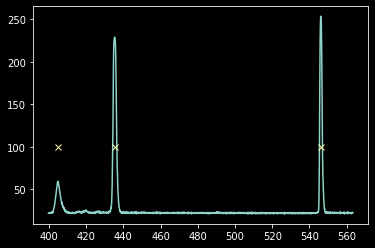

In [146]:
pl.plot(wavelengths, hg_spectrum)
pl.plot(guessed_wavelengths, [100]*3, 'x')

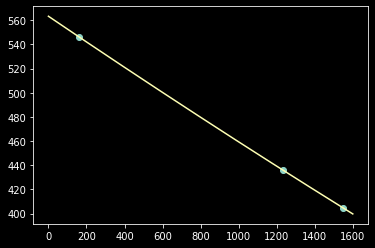

In [151]:
pl.plot(improved_xval_guesses, guessed_wavelengths, 'o')
pl.plot(xaxis, wavelengths, '-')

We can look up neon and krypton line lists to see how well we did and maybe try to improve our fit

In [147]:
from astroquery.nist import Nist
minwave = wavelengths.min()
maxwave = wavelengths.max()
krypton_lines = Nist.query(minwav=minwave, maxwav=maxwave, linename='Kr I')
neon_lines = Nist.query(minwav=minwave, maxwav=maxwave, linename='Ne I')
krypton_lines = krypton_lines[krypton_lines['Aki'] > 5e5]
neon_lines = neon_lines[neon_lines['Aki'] > 5e5]

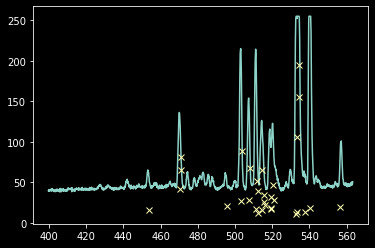

In [148]:
pl.plot(wavelengths, ne_spectrum)
pl.plot(neon_lines['Observed'], neon_lines['Aki']/5e4, 'x')

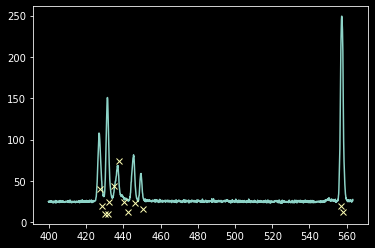

In [149]:
pl.plot(wavelengths, kr_spectrum)
pl.plot(krypton_lines['Observed'], krypton_lines['Aki'] / 5e4, 'x')

While it's clear that we got the fit about right, we can't obviously improve on our original fit because the NIST line lists give too many wavelengths for each peak.  Without knowing something more abouat the intensity profile of the lamps, we can't obviously do better.